In [1]:
from ipynb.fs.defs.Preprocessing_Module import read_data, add_topological, add_landcover, select_columns, reshape_dataset, fillna_dataset
from ipynb.fs.defs.Feature_Expansion_Module import feature_expansion
from ipynb.fs.defs.Initializer_Module import initializer
from ipynb.fs.defs.Neural_Network_Module import Dataset, transformations, FeedforwardNeuralNetModel, train_nn
from ipynb.fs.defs.Model_Validation_Module import validation_plots, metrics, eucleidian
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
np.set_printoptions(suppress=True)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# set the only_env as True if you want to use only environmental features
only_env = True
# set the name of the date column
date_col = 'dt_placement'
# set the model type. Could be 'class_regression' or 'mosquito_regression' or 'classification'
model_type = 'mosquito_regression'
# set the transform argument as True if you want to limit the target variable to 0-9 scale
transform_target = False
#set the data for embeddings e.g. data[['col', 'col2']]
embedded_data = None
#set the transformation actions of the data. Options are 'augmentation', 'normalization', 'log', 'scaling'
transformation_list = ['scaling']

In [3]:
data = read_data('../Datasets/Germany/GER_wuerttemberg_culex_2010_2023.csv')
columns = ['x', 'y', 'dt_placement',
           'culex.spp', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
           'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
           'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
           'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
           'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
           'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean' ]
names = ['x', 'y', 'dt_placement',
         'mosq_now', 'ndvi', 'ndwi', 'ndmi', 'ndbi',
         'ndvi_mean', 'ndvi_std', 'ndwi_mean', 'ndwi_std', 'ndmi_mean',
         'ndmi_std', 'ndbi_mean', 'ndbi_std', 'lst_day', 'lst_night',
         'acc_rainfall_1week', 'acc_rainfall_2week', 'acc_rainfall_jan',
         'lst_jan_day_mean', 'lst_feb_day_mean', 'lst_mar_day_mean', 'lst_apr_day_mean',
         'lst_jan_night_mean', 'lst_feb_night_mean', 'lst_mar_night_mean', 'lst_apr_night_mean']
data = select_columns(data,columns,names)
data = add_topological(data,'../Datasets/Topological Datasets/2x2grid/germany_wuerttemberg_2km_geo.csv')
data = add_landcover(data,'../Datasets/Landcover Datasets/2x2grid/germany_wuerttemberg_2km_lulc.csv')
data = reshape_dataset(data,['x','y','dt_placement'])
data = fillna_dataset(data,{'acc_rainfall_1week':0, 'acc_rainfall_2week':0, 'acc_rainfall_jan':0})

Index(['station_id', 'x', 'y', 'dt_placement', 'week', 'month', 'year',
       'country_code', 'nuts0_code', 'nuts0_name', 'nuts1_code', 'nuts1_name',
       'nuts2_code', 'nuts2_name', 'nuts3_code', 'nuts3_name',
       'lau1_municipality', 'lau2_settlement', 'trap_type', 'culex.spp',
       'region', 'dt_placement_original', 'indices_image_date', 'indices_lat',
       'indices_lon', 'ndvi', 'ndmi', 'ndwi', 'ndbi', 'ndvi_mean', 'ndmi_mean',
       'ndwi_mean', 'ndbi_mean', 'ndvi_std', 'ndmi_std', 'ndwi_std',
       'ndbi_std', 'lst_image_date', 'lst_lat', 'lst_lon', 'lst_day',
       'lst_night', 'monthly_lst_lat', 'monthly_lst_lon', 'lst_jan_day_mean',
       'lst_jan_night_mean', 'lst_feb_day_mean', 'lst_feb_night_mean',
       'lst_mar_day_mean', 'lst_mar_night_mean', 'lst_apr_day_mean',
       'lst_apr_night_mean', 'indices_image_date.1', 'indices_lat.1',
       'indices_lon.1', 'acc_rainfall_jan', 'dt_placement_minus_7',
       'dt_placement_minus_14', 'dt_placement_minus_7_avail

In [4]:
data = feature_expansion(data, env=only_env)

In [5]:
data = initializer(data, model_type, dropna=True)

In [6]:
test = data.sample(frac = 0.20,random_state=1)
train = data.drop(data.index[list(test.index)]).reset_index(drop=True)
test = test.reset_index(drop=True)

In [7]:
#define a nn 
model = FeedforwardNeuralNetModel(num_features=len(train.iloc[0,:])-2, num_class=1, encode_layers = [360,256,128],
                                  decode_layers = [128,256,360], latent_dim=5, dropout=[0.3,0,0],
                                  model_type=model_type, learning_rate = 0.001, epochs = 100, batch_size = 128,
                                  transformation_list = transformation_list, early_stop = None)

In [8]:
#preprocess nn input
del train[date_col]
date = test[date_col]
del test[date_col]

train_X, train_y, test_X, test_y = transformations(train, test = test, model_type = model.model_type, 
                                                   embedding_data = model.embedding_data,
                                                   transformation_list = model.transformation_list)

training_set = Dataset(train_X, train_y)

testing_set = Dataset(test_X, test_y)

Epoch 001: | Train Loss: 308.62300 | Val Loss: 64735.22406 | Train Acc: 7.201| Val Acc: 32.845
Epoch 002: | Train Loss: 273.45960 | Val Loss: 64328.53066 | Train Acc: 7.081| Val Acc: 32.609
Epoch 003: | Train Loss: 234.81131 | Val Loss: 63881.61466 | Train Acc: 6.671| Val Acc: 32.085
Epoch 004: | Train Loss: 217.92768 | Val Loss: 63531.51282 | Train Acc: 6.519| Val Acc: 31.706
Epoch 005: | Train Loss: 190.66659 | Val Loss: 63085.25989 | Train Acc: 6.120| Val Acc: 31.926
Epoch 006: | Train Loss: 168.68207 | Val Loss: 62966.48560 | Train Acc: 5.867| Val Acc: 31.615
Epoch 007: | Train Loss: 156.48911 | Val Loss: 62938.01304 | Train Acc: 5.734| Val Acc: 31.430
Epoch 008: | Train Loss: 143.06714 | Val Loss: 62472.43351 | Train Acc: 5.566| Val Acc: 31.342
Epoch 009: | Train Loss: 133.96006 | Val Loss: 62291.99465 | Train Acc: 5.427| Val Acc: 31.181
Epoch 010: | Train Loss: 130.53215 | Val Loss: 62289.08910 | Train Acc: 5.385| Val Acc: 31.415
Epoch 011: | Train Loss: 122.95746 | Val Loss: 623

Epoch 088: | Train Loss: 34.27051 | Val Loss: 61894.70450 | Train Acc: 2.938| Val Acc: 30.840
Epoch 089: | Train Loss: 33.91978 | Val Loss: 62029.82781 | Train Acc: 2.940| Val Acc: 31.035
Epoch 090: | Train Loss: 34.87482 | Val Loss: 61849.31094 | Train Acc: 2.976| Val Acc: 30.463
Epoch 091: | Train Loss: 32.59941 | Val Loss: 61860.17542 | Train Acc: 2.872| Val Acc: 30.706
Epoch 092: | Train Loss: 34.19172 | Val Loss: 62002.97686 | Train Acc: 2.928| Val Acc: 30.647
Epoch 093: | Train Loss: 36.94018 | Val Loss: 62023.83643 | Train Acc: 3.042| Val Acc: 30.668
Epoch 094: | Train Loss: 34.30124 | Val Loss: 61654.03680 | Train Acc: 2.937| Val Acc: 30.541
Epoch 095: | Train Loss: 30.99380 | Val Loss: 61807.75319 | Train Acc: 2.837| Val Acc: 30.584
Epoch 096: | Train Loss: 33.22258 | Val Loss: 62004.58642 | Train Acc: 2.869| Val Acc: 30.723
Epoch 097: | Train Loss: 34.59009 | Val Loss: 61897.54538 | Train Acc: 2.912| Val Acc: 30.513
Epoch 098: | Train Loss: 32.09633 | Val Loss: 61972.89630 | 

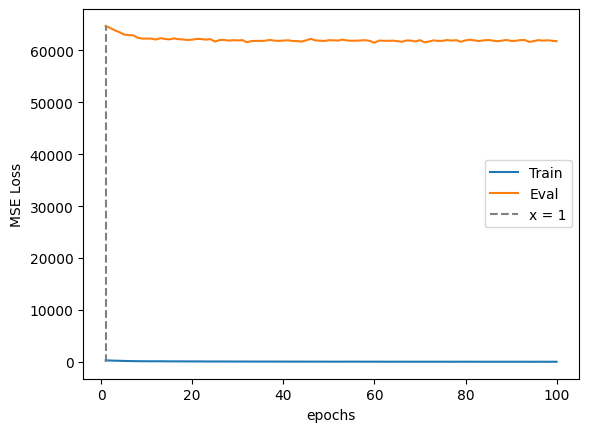

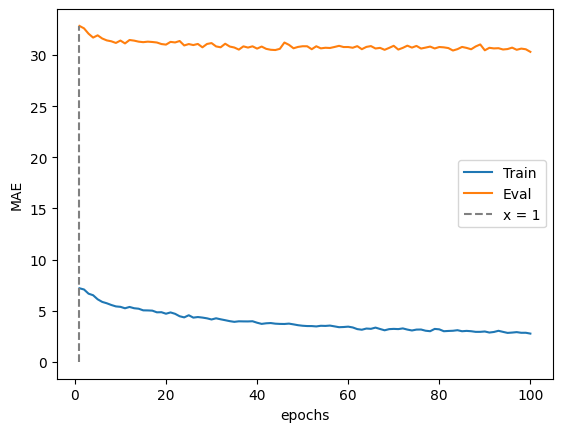

In [9]:
#train_nn
results_train, results_test, latent_train, latent_test, _ = train_nn(model = model, train_set = training_set,
                                                                     test_set = testing_set, features=None, max_val = train_y.max())

MAE on train set:  2.472832600878945
min prediction: 0
max prediction: 66

MAE on test set:  30.51558752997602
Error <= 30: 92.09 %
min prediction: 0
max prediction: 66


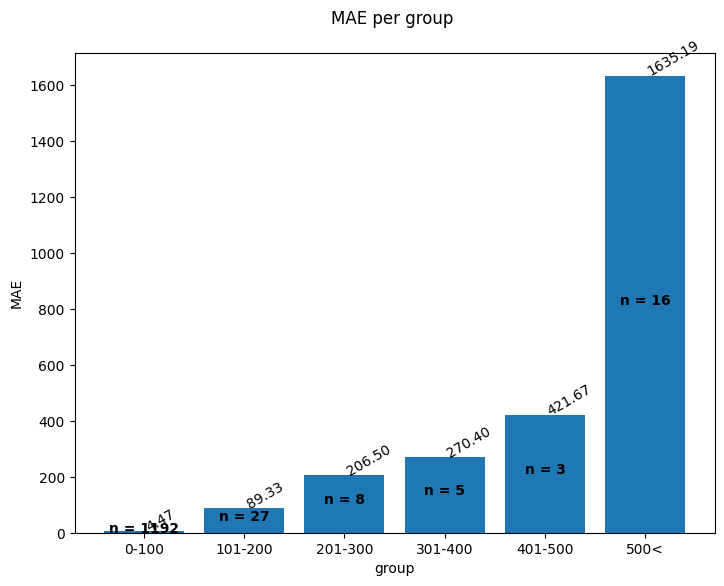

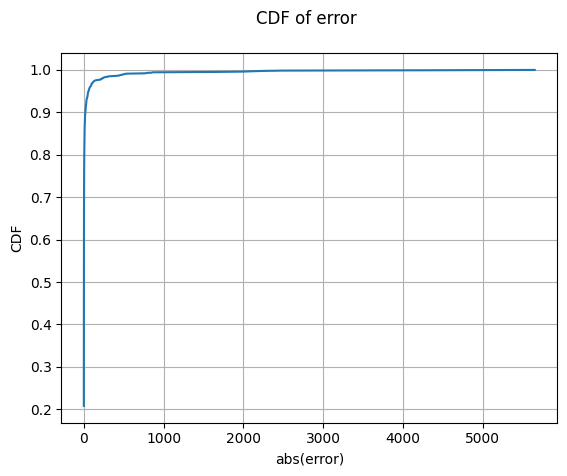

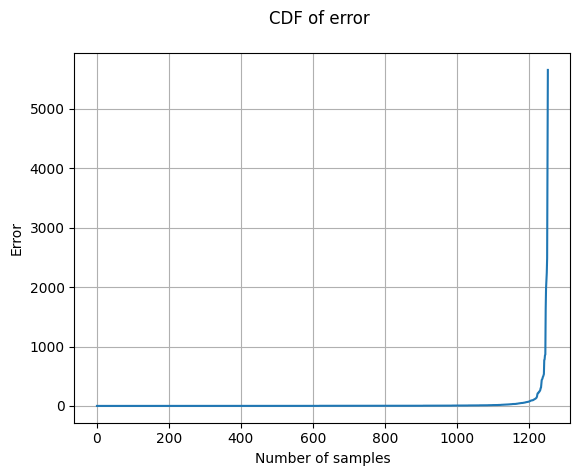

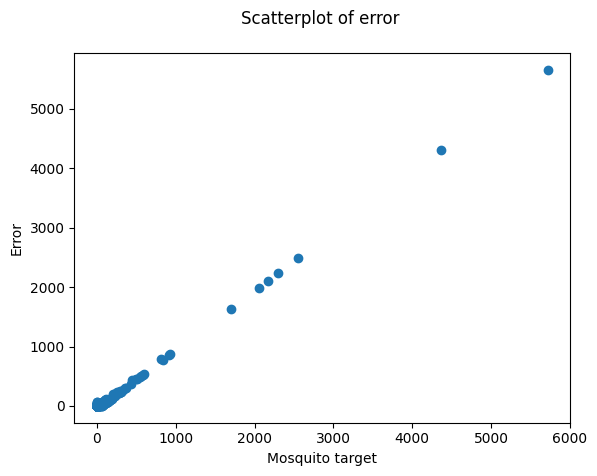

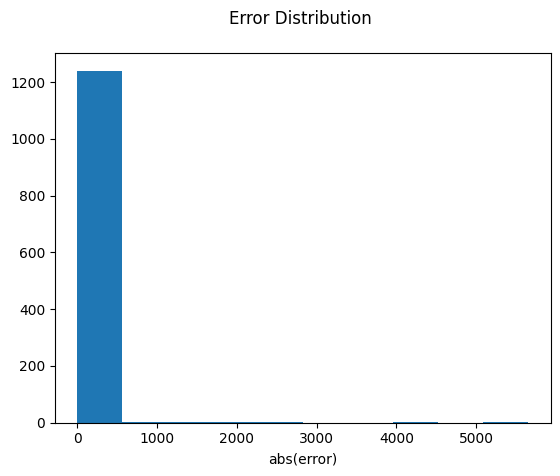

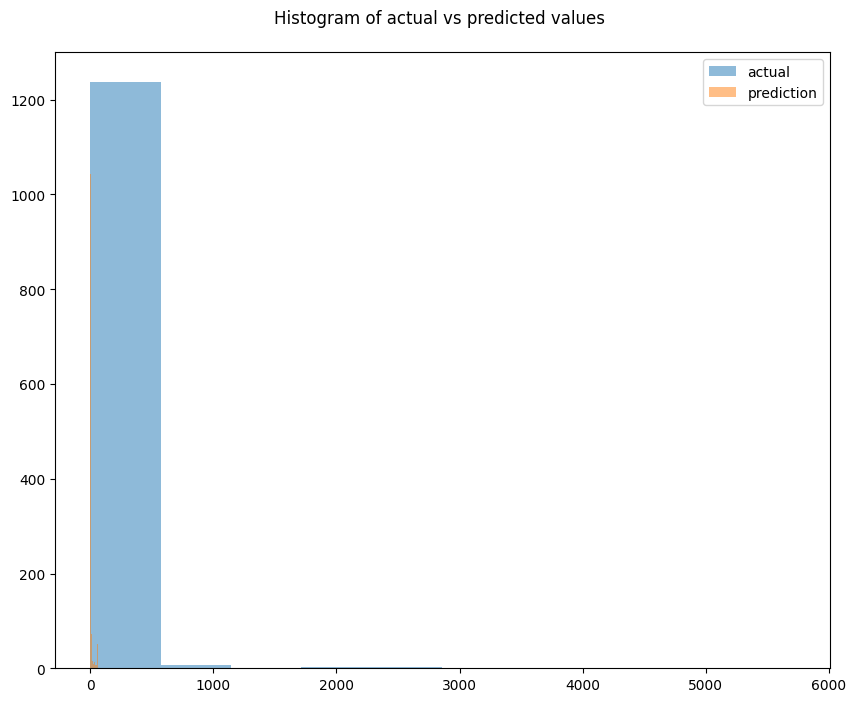

In [10]:
results_test[date_col] = date
results_test['dt_prediction'] = results_test[date_col] + datetime.timedelta(days=15)
results_test['error'] = results_test['actual'] - results_test['prediction']
results_test['abs(error)'] = np.abs(results_test['actual'] - results_test['prediction'])

if model_type == 'mosquito_regression':
    metrics(results_train, results_test, threshold=30)
else:
    metrics(results_train, results_test)
validation_plots(results_test,model_type)

In [11]:
results_train['error'] = results_train['actual'] - results_train['prediction']
results_train['abs(error)'] = np.abs(results_train['actual'] - results_train['prediction'])
results_train = pd.concat([results_train, pd.DataFrame(latent_train)],axis=1)
results_train

,actual,prediction,error,abs(error),0,1,2,3,4
0,0.0,0,0.0,0.0,0.535555,1.420932,0.528551,0.375502,2.426174
1,0.0,0,0.0,0.0,0.087404,1.780323,0.269115,1.097850,1.658464
2,0.0,1,-1.0,1.0,0.141825,-0.236075,-0.669363,-0.463282,2.187164
3,0.0,1,-1.0,1.0,-0.943698,-1.180014,2.599493,0.061170,0.073228
4,0.0,1,-1.0,1.0,-0.258283,-0.036633,-0.344498,-0.842250,1.718845
...,...,...,...,...,...,...,...,...,...
5001,0.0,9,-9.0,9.0,0.762093,0.751206,0.432685,-0.721768,0.827943
5002,69.0,55,14.0,14.0,-0.444554,0.224324,-0.355074,-0.742326,-0.475348
5003,1.0,0,1.0,1.0,-0.683484,0.533007,0.085154,-0.481096,2.226363
5004,2.0,3,-1.0,1.0,0.320031,2.224457,0.487835,-0.278234,0.286689


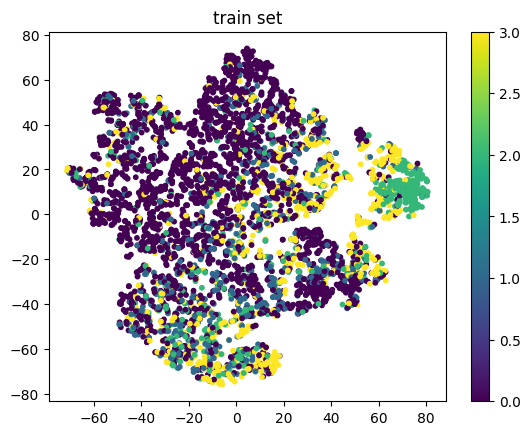

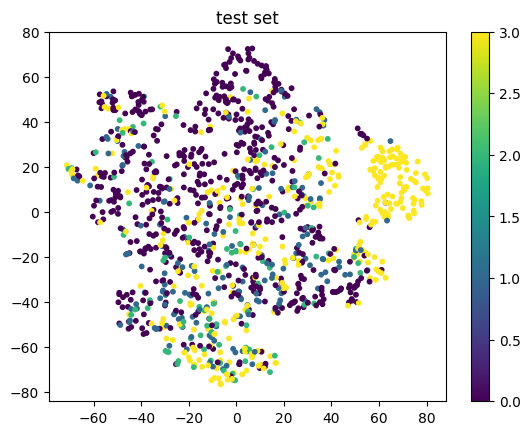

In [12]:
q=5
bins, bounds = pd.qcut(pd.concat([results_train['abs(error)'],results_test['abs(error)']]), retbins=True, q=q, duplicates='drop')

# q=[-1, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600]
# bins, bounds = pd.cut(pd.concat([results_train['abs(error)'],results_test['abs(error)']]), bins=q, retbins=True, labels=classes)

bins = bins.cat.codes
latent = np.concatenate((latent_train, latent_test))
colour_dots = pd.concat([results_train['abs(error)'], results_test['abs(error)']])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(latent)
X1_tsne = X_tsne[:latent_train.shape[0],:]
X2_tsne = X_tsne[latent_train.shape[0]:,:]

# Visualize the t-SNE result
plt.scatter(X1_tsne[:, 0], X1_tsne[:, 1], c=bins[:latent_train.shape[0]], s=10)
plt.colorbar()
plt.title('train set')
plt.show()

plt.scatter(X2_tsne[:, 0], X2_tsne[:, 1], c=bins[latent_train.shape[0]:], s=10)
plt.colorbar()
plt.title('test set')
plt.show()

In [13]:
#keep only train observations with error less than MAE
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean(), 0:].reset_index(drop=True)
results_good

,0,1,2,3,4
0,0.535555,1.420932,0.528551,0.375502,2.426174
1,0.087404,1.780323,0.269115,1.097850,1.658464
2,0.141825,-0.236075,-0.669363,-0.463282,2.187164
3,-0.943698,-1.180014,2.599493,0.061170,0.073228
4,-0.258283,-0.036633,-0.344498,-0.842250,1.718845
...,...,...,...,...,...
3564,-0.423210,1.724582,0.139981,-0.042462,1.355290
3565,-0.536288,1.107816,1.364052,-0.003921,0.145954
3566,-0.683484,0.533007,0.085154,-0.481096,2.226363
3567,0.320031,2.224457,0.487835,-0.278234,0.286689


In [14]:
percentage =0.2

In [15]:
euc_M_dist = eucleidian(np.array(results_good), latent_test, 3)
results_test['dist'] = euc_M_dist
results_test_latent = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_latent.corr().loc['abs(error)','dist'])
print("good:", results_test_latent.iloc[:round(len(results_test_latent)*percentage)]['abs(error)'].mean())
print("bad:", results_test_latent.iloc[-round(len(results_test_latent)*percentage):]['abs(error)'].mean())

correlation: 0.15918864486951084
good: 3.248
bad: 104.876


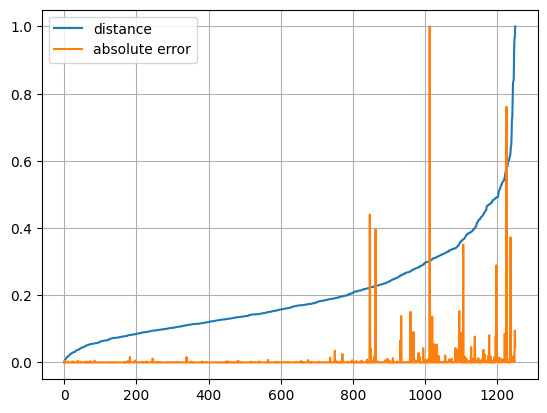

In [16]:
distance = (results_test_latent['dist'] - results_test_latent['dist'].min())/(results_test_latent['dist'].max()-results_test_latent['dist'].min())
error=(results_test_latent['abs(error)']-results_test_latent['abs(error)'].min())/(results_test_latent['abs(error)'].max()-results_test_latent['abs(error)'].min())
plt.plot(distance, label='distance')
plt.plot(error, label='absolute error')
plt.legend()
plt.grid()
plt.show()

In [17]:
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean()].index
results_good = train_X[0][results_good,:]

euc_M_dist = eucleidian(results_good, test_X[0], 3)
results_test['dist'] = euc_M_dist
results_test.corr()
results_test_fs = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_fs.corr().loc['abs(error)','dist'])
print("good:", results_test_fs.iloc[:round(len(results_test_fs)*percentage)][ 'abs(error)'].mean())
print("bad:", results_test_fs.iloc[-round(len(results_test_fs)*percentage):]['abs(error)'].mean())

correlation: 0.08038922363119579
good: 12.748
bad: 75.716


In [18]:
results_good = results_train.loc[results_train['abs(error)']<results_train['abs(error)'].mean()].index
results_good = train.loc[results_good,['x','y']]

euc_M_dist = eucleidian(np.array(results_good.drop_duplicates().reset_index(drop=True)), np.array(test[['x','y']]), 3)
results_test['dist'] = euc_M_dist
results_test.corr()
results_test_coord = results_test.sort_values(by=['dist','abs(error)']).reset_index(drop=True)
print('correlation:', results_test_coord.corr().loc['abs(error)','dist'])
print("good:", results_test_coord.iloc[:round(len(results_test_coord)*percentage)]['abs(error)'].mean())
print("bad:", results_test_coord.iloc[-round(len(results_test_coord)*percentage):]['abs(error)'].mean())

correlation: -0.01473149387414735
good: 22.592
bad: 19.012
